# **QSolid – User Documentation**
# *Quantum Computer in the Solid State (www.q-solid.de)*
*The QSolid project acknowledges the support of the Federal Ministry of Education and Research (BMBF) within the framework programme “Quantum technologies – from basic research to market”.*
<br>

## Introduction
This documentation intends to provide all relevant information about the access to the QSolid QPUs to members of the QSolid project.  All partners of QSolid can access this documentation as well as the QSolid QPUs (once available).  In this early development phase of the project everything is still subject to change, so some additional steps for individual software installations or configurations are necessary, which will be part of the standard JUNIQ evironment later.  One stated goal of the project is to make access as user friendly as possible, so if you experience any problems or have ideas for improvement, please contact one of the workpackage 10 partners.

The recommended way to access the QSolid project QPU is to use the Eviden myQLM Python client software.  myQLM is already installed in the JUNIQ Jupyter Lab environment, but is also available as open source software for personal installations.  For detailed myQLM documentation please refer to https://myqlm.github.io/.  Although the myQLM already allows to import circuit descriptions of other quantum programming frameworks (e.g. Qiskit), the QSolid user interface will be extended over time to make the direct use of different input formats as easy as possible.

<br>

## System design and workflow

In order to ensure a coordinated access to the QPU, all user jobs need to be submitted and put into a queue,
which will schedule and dispatch jobs as efficiently as possible and return the results in a asynchronous way.
The myQLM client software offers a bundle of useful functions for job creation and job submit and can be used
either from within a Jupyter Notebook or some stand alone Python scripts.

Unless there are special requirements, the user does not necessarily need to know the details of the underlying
systems.  These work package 10 partner components are:
* ParTec ParaStation Modulo for job scheduling
* Qruise Toolstack for QPU access
* ParityQC compiler for specific optimization.

**The job flow for regular jobs (pure quantum or variational hybrid algorithms) will look like this:**

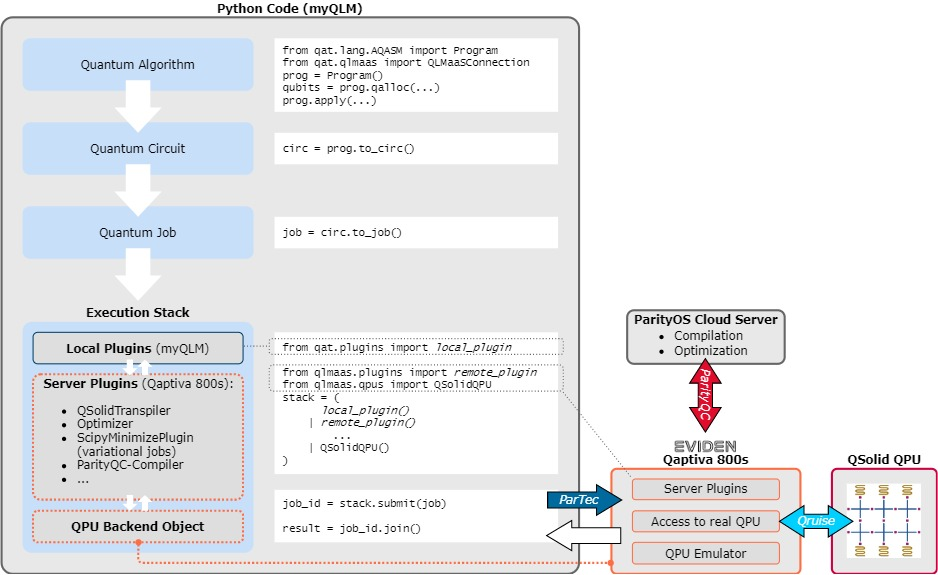

<br>

## Installation and configuration of required software components

### Required software
The QSolid infrastructure for user access to the QPU consists of numerous different components with different functions.  These are:
* **JUNIQ Web Frontend:**
   * Authentication and Login
   * Platform for interaction with JSC infrastructure
   * User needs:
      * JuDoor user account - *no anonymous access possible* yet
      * Access to JuDoor project `QLM` - *permission to use QLM/Qaptiva*
      * Upload of SSH key to JuDoor - *recommended for direct access*
* **myQLM client software:**
   * Python quantum programming environment
   * Access point to QLM/Qaptiva and job submission interface for quantum computing jobs
   * User needs:
      * myQLM client software - *installed in JUNIQ Jupyter Lab environment or available as openSource for individual installation*
      * Python package `qlmaas`
      * Configuration file `~/.qlmaas/cofig.ini`
      * Get SSL certificate from JSC:  `jurecaqlm:~/.ssl` - *required for connection to QLM/Qaptiva*
* **Qaptiva 800s:**
   * Hardware agnostic quantum computing emulator
   * Large variety of compilers, optimizers, other plugins or specific hardware simulators
   * QC/variational jobs can be scheduled equally for real and simulated quantum hardware
* **Qruise client software:**
   * Required for access to QSolid QPU - *has to be installed and configured on Qaptiva appliance (`jurecaqlm.fz-juelich.de`)*
   * User needs:
      * User account/password for QruiseOS server
      * Python package `qruise-qc-remote`
      * Configuration file `~/.config/qruise/profiles.cfg`
   * "Digital Twin" of QPU for detailed physical quantum  computing simulations
* **ParTec ParaStation Modulo:**
   * Sophisticated scheduling system used for job queueing
   * No direct user interaction necessary
   * Job control possible with standard Slurm commandline on any Slurm client node
* **ParityQC:**
   * Special purpose compiler, which maps the quantum circuit to the ParityOS scheme (gereralized LHZ scheme)
   * Can be easily included into workflow as Qaptiva plugin once available
   * User needs ParityQC cloud access

<br>

### Installation and configuration steps
*Note: In production, steps 3 to 5 will not be needed anymore.  Steps 1 & 2 will also be simplified significantly.*

#### Client side: set up PowerAccess to Qaptiva (@ `juniq.fz-juelich.de`)

1. **Get access to Qaptiva:**
    1. **User:**
       * request access to QLM project on Judoor
    1. **Principal Investigator/Project Admin:**
       * grant access to project
    1. **User:**
       * upload SSH key on JuDoor,
    1. **JSC:**
       * create user-certificate, copy to home directory of user `jurecaqlm:~/.ssl`
<br>
2. **Set up PowerAccess:**
    2. **User:**
       * copy user-certificate to JUNIQ (local terminal): `scp -r <user_name>@jurecaqlm.fz-juelich.de:~/.ssl .`
       * log into JUNIQ
       * drag and drop certificate files into `JUNIQ:~/.ssl`
       * execute these lines, change filenames under `.ssl` if different:

```
mkdir ~/.qlmaas

cat <<EOF >~/.qlmaas/config.ini
[Server]
hostname = jurecaqlm-proxy.fz-juelich.de
port = 443
check_host = False
authentication = ssl
timeout = 600
proxy_host=
proxy_port=

[SSL]
certificate=~/.ssl/qlmaas.cer
key=~/.ssl/qlmaas.key
EOF

pip install --user qlmaas==1.7.2
```


#### Server-side: install `qruise-qc-remote` (@ `jurecaqlm`)

3. **Install Qruise access (`qruiseqc-remote`):**
   * **Qruise:**
      * give PAT_TOKEN and PGI username+password to **User**:
   * **User:**
      * install `qruise-qc-remote` (with individual `<PAT_TOKEN>` replaced): <br>
```
pip install --user scipy==1.9.3 rustworkx==0.12.0 qruise-qc-remote --extra-index-url=https://__token__:<PAT_TOKEN>@gitlab.com/api/v4/projects/50586171/packages/pypi/simple
pip install --user attrs==23.1.0
```
<br>  *Note: Ignore "qcs-api-client 0.21.2 requires attrs\<21.0.0,\>=20.1.0, but you have attrs 23.1.0 which is incompatible."* <br>

4. **Cofigure Qruise access (`profiles.cfg`):**
   * **User**:
      * Open `~/.config/qruise/profiles.cfg` with text editor (e.g. `vim ~/.config/qruise/profiles.cfg`):
      * Paste following contents (with individual `<PGI user>` and `<PGI password>` credentials replaced):
```
[qc-ext]
host = rabbitmq-broker.dev.qruise.eu
port = 443
virtual_host = qc-ext
username = <PGI user>
password = <PGI password>
connection = CELERY+AMQP
```
<br>

5. **Install & configure QSolid modules for Qaptiva remote access to Qruise toolstack:**
   * **User:**
```
cp /usr/local/share/qsolid/qruise_qpu.py ~/qruise_qpu.py
cp /usr/local/share/qsolid/.qlm_env ~/.qlm_env
```
<br>

## Testing of PowerAccess


In [ ]:
from qat.lang.AQASM import CNOT, H, Program
from qlmaas.qpus import LinAlg

qprog = Program()
qbits = qprog.qalloc(2)
H(qbits[0])
CNOT(qbits[0], qbits[1])

circuit = qprog.to_circ()
job = circuit.to_job()
qpu = LinAlg()
result = qpu.submit(job).join()

print("State vector =", result.statevector)
for sample in result:
    print(sample.state, sample.probability)


<br>

## Short description of user interface

### Usage of native myQLM:

#### Alternatives for creation of quantum jobs:

##### **Manual circuit declaration (`Program` class): <br> (Alternative 1)**



In [ ]:
# The most relevant object are defined in "qat.core" and "qat.lang" (qat = "Qaptiva Application Toolset"):
from qat.lang.AQASM import CNOT, H, Program
from qlmaas.qpus import LinAlg

# Initialize quantum program:
prog = Program()

# Allocate qubits:
qbits = prog.qalloc(2)

# Apply gates - available gates are:  'CCNOT', 'CNOT', 'CSIGN', 'CustomGate', 'H', 'I', 'ISWAP', 'PH', 'RX', 'RY', 'RZ', 'S', 'SQRTSWAP', 'SWAP', 'T', 'X', 'Y', 'Z'
H(qbits[0])
CNOT(qbits[0], qbits[1])

# Create circuit object:
circ = prog.to_circ()

# Display circuit:
circ.display()

# Create quantum job:
job = circ.to_job()

# Choose QPU backend for job, i.e. Qaptiva emulator (LinAlg):
qpu = LinAlg()

# Submit job to scheduler:
jobid = qpu.submit(job)

# Wait for end of job and join result:
result = jobid.join()

# Print result:
print("State vector =", result.statevector)
for sample in result:
    print(sample.state, sample.probability)

<br>

##### **Using predefined quantum routine `"qrout"` (new in myQLM-1.9.x): <br> (Alternative 2)**


In [ ]:
import sys
sys.path.insert(0, "/home/jovyan/.local/lib/python3.8/site-packages")

from qat.lang.AQASM import CNOT, H, qrout
from qlmaas.qpus import LinAlg

@qrout
def bell_pair():
    H(0)
    CNOT(0, 1)

# The resulting object can be called as a function:
bell_pair().display()

with LinAlg():
    result = bell_pair.run()

for sample in result:
    print(sample.state, sample.probability)

<br>

#### Using plugins:
Within the Qaptiva framework, **plugins** are one of the most important means to modify and manipulate quantum circuits or jobs.  Besides a large amount of predefined plugins for different purposes it is also possible to write your own plugins.  <br><br> A list of standard Qaptiva plugins can be found here: <br> http://jurecaqlm-proxy.fz-juelich.de/doc/04_api_reference/module_qat/module_plugins.html#module-qat.plugins <br>

For example, plugins are used for compilers and optimizers like `NISQCompiler` or `ScipyMinimizePlugin`.  Within the QSolid project we are currently developing compiler plugins for the QSolid QPU to be built.  These compilers highly depend on the available information of the QPU (native gateset, topology, connectivity, noise data, etc.) and will evolve accordingly.

A sorted list of plugins in combination with a QPU backend are called a "stack".  When using local (myQLM) and remote (QaptivaAccess) plugins, it is important to put the local plugins before the remote plugins.  Please note that all plugins are applied to the *input* of a job **and** to the *result* of a job (in reverse order): <br>

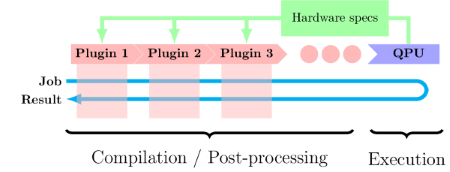

<br>

 A `job` can be submitted directly to a `stack`.  The syntax for combining plugins and creating a stack is rather simple:

<div class="alert alert-block alert-info">

```
from qat.plugins import local_plugin1, local_plugin2
from qlmaas.plugins import remote_plugin3, remote_plugin4
from qlmaas.qpus import my_remote_qpu

stack = (
      local_plugin1
    | local_plugin2
    | remote_plugin3
    | remote_plugin4
    | my_remote_qpu()
)

stack.submit(job)

```

</div>

#### Different QPU backends:
One of the major benefits of Qaptiva is the possibility to run your quantum jobs on either a QPU emulator or on a real QPU in the exact same manner.  From a programming point of view you only run your job on a different QPU backend object.
<br><br> A list of standard Qaptiva QPU backends can be found here: <br> http://jurecaqlm-proxy.fz-juelich.de/doc/04_api_reference/module_qat/module_qpus.html#module-qat.qpus <br><br>
The QSolid QPU does not exist yet, but you can still test your workflow with an emulated QPU like `LinAlg` or `NoisyQProc`.  Or, if you have access credentials for the Qruise Server, you can also access the Qruise toolstack by using the `QruiseQPU` backend (see section *"Example – smoke test 1"*).

<br>

### Usage of Qiskit input:

 <font color='red'>***. . . UNDER CONSTRUCTION . . .***</font>

<br>

## Examples

### Example – smoke test 1:


In [ ]:
import sys
import datetime

DEBUG = True

def dprint(label=None):
    if DEBUG:
        if not label:
            import inspect

            label = "line number %s" % inspect.currentframe().f_lineno
        print(
            "DEBUG: %-50s" % label,
            datetime.datetime.now().isoformat(sep=" ", timespec="seconds"),
            file=sys.stderr,
        )


dprint("START")

from qat.lang.AQASM import CNOT, RX, H, Program
from qat.qlmaas import QLMaaSConnection

dprint("  QLMaas connected...")

qprog = Program()
dprint("  Program created...")

qubits = qprog.qalloc(1)
dprint("  Qubits allocated...")

qprog.apply(RX(0.22), qubits[0])
circuit = qprog.to_circ()
dprint("  Circuit created...")

job = circuit.to_job()
dprint("  Job created...")

from qlmaas.qpus import QruiseQPU

dprint("  QruiseQPU imported...")

stack = QruiseQPU()
dprint("  Stack created...")

submitted_job = stack.submit(job)
dprint("  Job submitted...")

result = submitted_job.join()
print("QPU RESPONSE =", complex(result.meta_data["qpu_response"]))
dprint("END")

### Example – variational algorithm:

In [ ]:
import sys

sys.path.append("/home/jovyan/.local/lib/python3.8/site-packages")

from qat.core import Observable as Obs
from qat.core import Term
from qat.lang.AQASM import CNOT, RY, Program
from qat.qlmaas import QLMaaSConnection
from qlmaas.plugins import ScipyMinimizePlugin
from qlmaas.qpus import LinAlg, QruiseQPU

# we instantiate the Hamiltonian we want to approximate the ground state energy of
hamiltonian = (
    Obs.sigma_z(0, 2) * Obs.sigma_z(1, 2)
    + Obs.sigma_x(0, 2) * Obs.sigma_x(1, 2)
    + Obs.sigma_y(0, 2) * Obs.sigma_y(1, 2)
)

# we construct the variational circuit (ansatz)
prog = Program()
reg = prog.qalloc(2)
thetas = [prog.new_var(float, "\\theta_%s" % i) for i in range(2)]
RY(thetas[0])(reg[0])
RY(thetas[1])(reg[1])
CNOT(reg[0], reg[1])
circ = prog.to_circ()

# construct a (variational) job with the variational circuit and the observable
job = circ.to_job(observable=hamiltonian)

# we now build a stack that can handle variational jobs

# Remark: Real QPU cannot yet handle required gate set, use "LinAlg" as emulator instead:
# qpu = QruiseQPU()
qpu = LinAlg()

optimizer_scipy = ScipyMinimizePlugin(
    method="COBYLA", tol=1e-6, options={"maxiter": 200}, x0=[0, 0]
)
stack = optimizer_scipy | qpu

# we submit the job and print the optimized variational energy (the exact GS energy is -3)
result = stack.submit(job)
# the output of the optimizer can be found here
print(result.meta_data["optimizer_data"])
print(f"Minimum VQE energy = {result.value}")

<br>

## Further documentation

* **myQLM:**
    * https://myqlm.github.io/
* **JSC Qaptiva:**
    * http://jurecaqlm-proxy.fz-juelich.de/doc/search.html

  

<br>

## HPC integration

 <font color='red'>***. . . UNDER CONSTRUCTION . . .***</font>